### Assignment 4: TKO_7096-3001 Computer Vision and Sensor Fusion


Goal: develop a RGB-Depth fusion architecture for semantic segmentation based on Fully Convolutional Network (FCN) .


<font color='red'> Deadline: 25.03.2024 at 24:00.

- Imports go here

In [10]:
import os
import numpy as np
from tensorflow.keras.utils import Sequence
import matplotlib.pyplot as plt
import random
from tensorflow.keras.optimizers import SGD
import tensorflow as tf
from tensorflow.keras.utils import Sequence

### Load the dataset and Ground-truth###

- Dataset consists of 1100 (per modality) images of road scenes. It is divided into train (600 images), test (200 images) and validation (300 images) datasets.
- Change the size of all images into 256*256.
- Converting the labels into one hot encoding
- Create a DataLoader for loading the files when training the model.

In [8]:

# Get the current working directory (this is where your notebook is located)
project_path = os.getcwd()
print("Project folder contents:", os.listdir(project_path))

# Define the dataset path by joining the project path with 'dataset'
dataset_path = os.path.join(project_path, 'dataset')
print("Dataset folder contents:", os.listdir(dataset_path))


Project folder contents: ['.ipynb_checkpoints', 'Assignment4.pdf', 'Assignment4_template.ipynb', 'dataset', 'dataset.zip']
Dataset folder contents: ['test', 'train', 'validation']


In [12]:
class DataLoader(Sequence):
    def __init__(self, rgb_files, depth_files, label_files, batch_size=32, shuffle=True):
        self.rgb_files = rgb_files
        self.depth_files = depth_files
        self.label_files = label_files
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.rgb_files))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.rgb_files) / self.batch_size))
    
    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_indexes = self.indexes[start:end]
        
        batch_rgb_files = [self.rgb_files[k] for k in batch_indexes]
        batch_depth_files = [self.depth_files[k] for k in batch_indexes]
        batch_label_files = [self.label_files[k] for k in batch_indexes]
        
        X_rgb, X_depth, y = self.__generate_data(batch_rgb_files, batch_depth_files, batch_label_files)
        return (X_rgb, X_depth), y
    
    def __generate_data(self, batch_rgb_files, batch_depth_files, batch_label_files):
        X_rgb = []
        X_depth = []
        y = []
        
        for rgb_file, depth_file, label_file in zip(batch_rgb_files, batch_depth_files, batch_label_files):
            # Load the .npy files
            rgb = np.load(rgb_file)
            depth = np.load(depth_file)
            label = np.load(label_file)
            
            # Resize the RGB image to 256x256 and ensure it has 3 channels
            rgb_resized = tf.image.resize(rgb, (256,256)).numpy()
            if rgb_resized.ndim == 2 or rgb_resized.shape[-1] != 3:
                rgb_resized = np.stack([rgb_resized]*3, axis=-1)
            
            # Resize the Depth image to 256x256 and ensure it has 3 channels
            depth_resized = tf.image.resize(depth, (256,256)).numpy()
            if depth_resized.ndim == 2 or depth_resized.shape[-1] != 3:
                if depth_resized.ndim == 2:
                    depth_resized = np.expand_dims(depth_resized, axis=-1)
                depth_resized = np.repeat(depth_resized, 3, axis=-1)
            
            # Resize the Label image using nearest neighbor interpolation
            # Expand dims if needed so that tf.image.resize works properly
            if len(label.shape) == 2:
                label = np.expand_dims(label, axis=-1)
            label_resized = tf.image.resize(label, (256,256), method='nearest').numpy()
            # Remove the extra channel if present (labels should be 2D)
            if label_resized.shape[-1] == 1:
                label_resized = np.squeeze(label_resized, axis=-1)
            
            # One-hot encode the label for 19 classes and then flatten it to (256*256, 19)
            label_onehot = tf.one_hot(label_resized.astype(np.int32), depth=19).numpy()
            label_onehot = label_onehot.reshape((256*256, 19))
            
            X_rgb.append(rgb_resized)
            X_depth.append(depth_resized)
            y.append(label_onehot)
        
        X_rgb = np.array(X_rgb)
        X_depth = np.array(X_depth)
        y = np.array(y)
        return X_rgb, X_depth, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [14]:
# Define dataset subfolder paths (update project_path if needed)
train_folder = os.path.join(dataset_path, 'train')
val_folder   = os.path.join(dataset_path, 'validation')
test_folder  = os.path.join(dataset_path, 'test')

# Function to generate file lists for each modality in a given folder
def get_file_lists(folder):
    rgb_files = sorted([os.path.join(folder, 'rgb', f) for f in os.listdir(os.path.join(folder, 'rgb')) ])
    depth_files = sorted([os.path.join(folder, 'depth', f) for f in os.listdir(os.path.join(folder, 'depth'))])
    label_files = sorted([os.path.join(folder, 'label', f) for f in os.listdir(os.path.join(folder, 'label')) ])
    return rgb_files, depth_files, label_files

# Create file lists for train, validation, and test sets
train_rgb_files, train_depth_files, train_label_files = get_file_lists(train_folder)
val_rgb_files, val_depth_files, val_label_files = get_file_lists(val_folder)
test_rgb_files, test_depth_files, test_label_files = get_file_lists(test_folder)



- Visualize the data you have prepared 

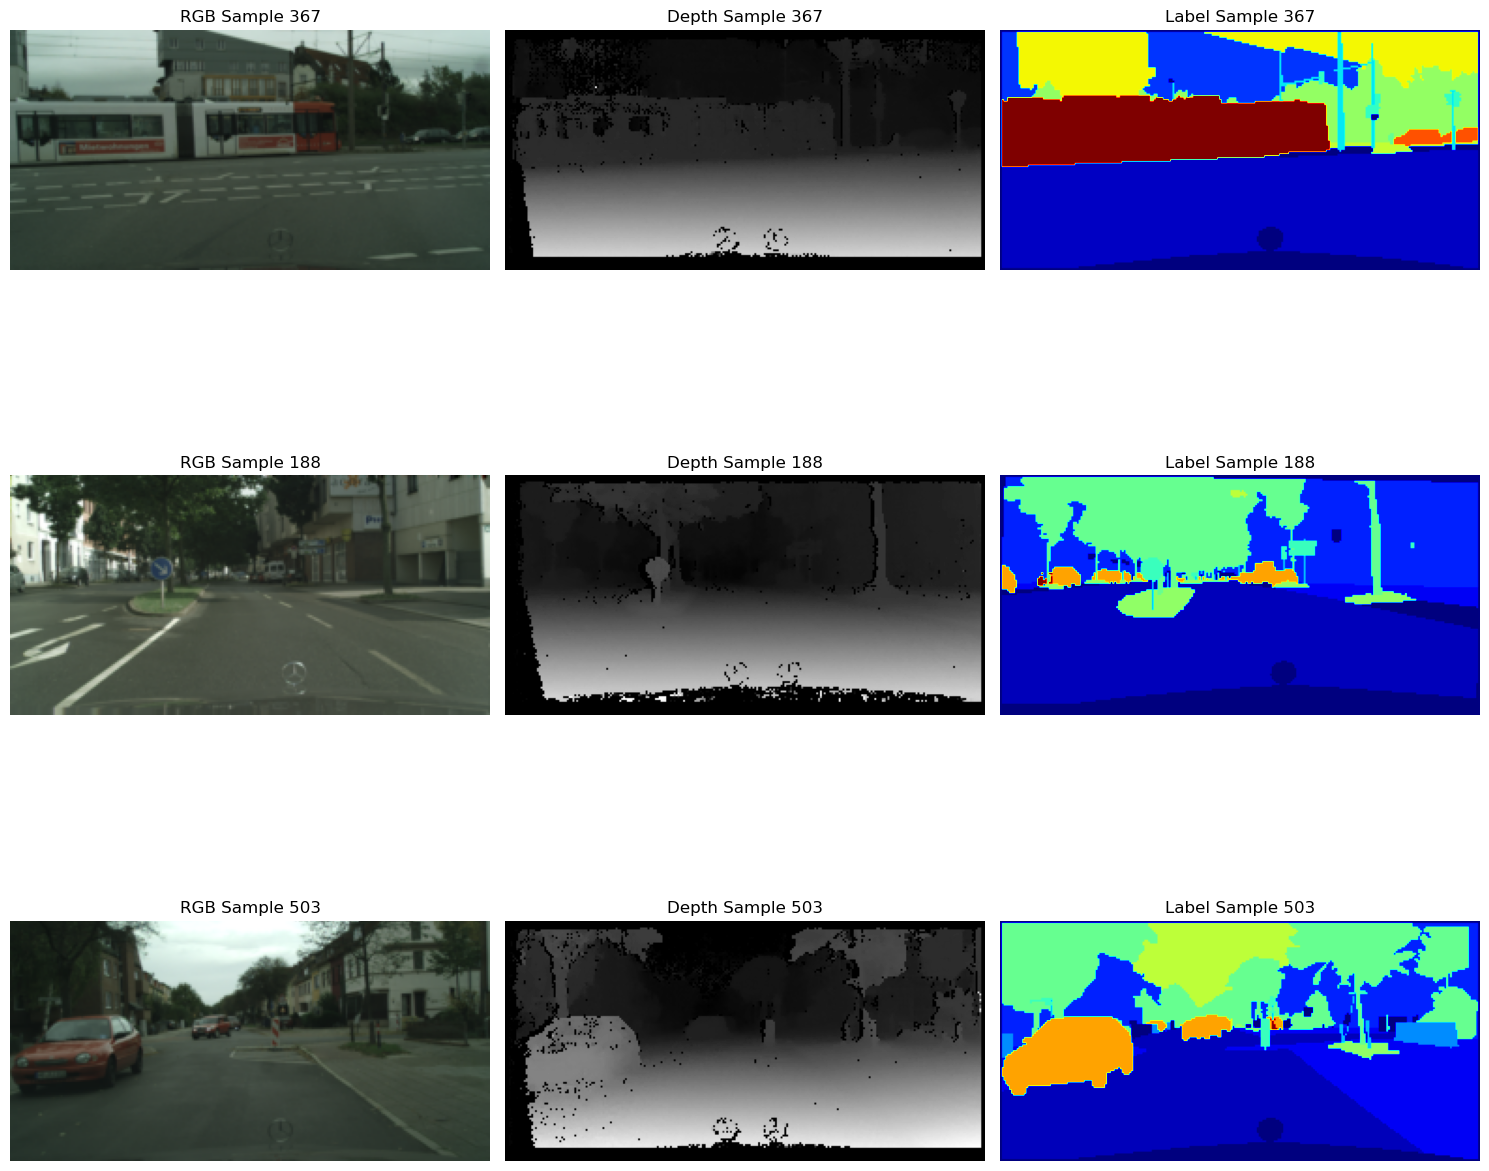

In [16]:
# Choose a few random indices from the training set
sample_indices = random.sample(range(len(train_rgb_files)), 3)

plt.figure(figsize=(15, 5 * len(sample_indices)))
for i, idx in enumerate(sample_indices):
    # Load the sample data for each modality
    rgb = np.load(train_rgb_files[idx])
    depth = np.load(train_depth_files[idx])
    label = np.load(train_label_files[idx])
    
    # Scale the normalized RGB image to 0-255 for proper visualization
    scaled_rgb = (rgb * 255).astype('uint8')
    
    # Visualize the RGB image
    plt.subplot(len(sample_indices), 3, i*3 + 1)
    plt.imshow(scaled_rgb)
    plt.title(f"RGB Sample {idx}")
    plt.axis('off')
    
    # Visualize the Depth image (using a grayscale colormap)
    plt.subplot(len(sample_indices), 3, i*3 + 2)
    plt.imshow(depth, cmap='gray')
    plt.title(f"Depth Sample {idx}")
    plt.axis('off')
    
    # Visualize the Label image (using a jet colormap to show segmentation classes)
    plt.subplot(len(sample_indices), 3, i*3 + 3)
    plt.imshow(label, cmap='jet')
    plt.title(f"Label Sample {idx}")
    plt.axis('off')

plt.tight_layout()
plt.show()


 Define a Fully Convolutional Network (FCN) for image segmentaion by fusing RGB and depth images. The network consists of  two sterams which each stream has following layers:

    1. Use the pretrained ResNet50 on imageNet
    2. Add two Conv layers with 128 and 256 nodes, respectively. Kernel size (3,3), stride (1,1)
    3. Top of the Conv layers, add dropout layer with 0.2
    4. Concatenate two streams.
    5. Add a transposed convolution layer (Conv2DTranspose)  with Kernel size (64,64), stride (32,32)
    6. Add a softmax activation layer
    
 You can find the model summary and structure in the PDF file.


In [47]:
#tf.keras.backend.clear_session()

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Conv2D, Dropout, Concatenate, Conv2DTranspose, Reshape, Activation
from tensorflow.keras.models import Model

def build_fusion_model(input_shape=(256,256,3), num_classes=19):
    # Define input layers for RGB and Depth modalities
    input_rgb = Input(shape=input_shape, name='input_rgb')
    input_depth = Input(shape=input_shape, name='input_depth')
    
    # Instantiate the ResNet50 models using input_shape instead of input_tensor.
    resnet_rgb = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape, name='resnet50_rgb')
    resnet_depth = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape, name='resnet50_depth')
    
    # Pass the custom inputs through each model separately.
    x_rgb = resnet_rgb(input_rgb)
    x_depth = resnet_depth(input_depth)
    
    # Add two Conv2D layers for each stream (128 and 256 filters, kernel (3,3), stride (1,1))
    x_rgb = Conv2D(128, (3,3), strides=(1,1), padding='same', activation='relu', name='rgb_conv1')(x_rgb)
    x_rgb = Conv2D(256, (3,3), strides=(1,1), padding='same', activation='relu', name='rgb_conv2')(x_rgb)
    x_rgb = Dropout(0.2, name='rgb_dropout')(x_rgb)
    
    x_depth = Conv2D(128, (3,3), strides=(1,1), padding='same', activation='relu', name='depth_conv1')(x_depth)
    x_depth = Conv2D(256, (3,3), strides=(1,1), padding='same', activation='relu', name='depth_conv2')(x_depth)
    x_depth = Dropout(0.2, name='depth_dropout')(x_depth)
    
    # Concatenate the two streams
    x = Concatenate(name='concatenate')([x_rgb, x_depth])
    
    # Add a transposed convolution layer with kernel size (64,64) and stride (32,32)
    x = Conv2DTranspose(num_classes, (64,64), strides=(32,32), padding='same', activation='relu', name='conv2d_transpose')(x)
    
    # Add a reshape layer to convert output shape to (256*256, num_classes)
    x = Reshape((256*256, num_classes), name='reshape')(x)
    
    # Add a final softmax activation layer for pixel-level classification
    outputs = Activation('softmax', name='softmax')(x)
    
    model = Model(inputs=[input_rgb, input_depth], outputs=outputs, name='Fusion_FCN')
    return model

fusion_model = build_fusion_model()
fusion_model.summary()


Model: "Fusion_FCN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_rgb           │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_depth         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50_rgb        │ (None, 8, 8,      │ 23,587,712 │ input_rgb[0][0]   │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50_depth      │ (None, 8, 8,      │ 23,587,712 │ input_depth[0][0] │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rgb_conv1 (Conv2D)  │ (None, 8, 8, 128) │  2,359,424 │ resnet50_rgb[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depth_conv1         │ (None, 8, 8, 128) │  2,359,424 │ resnet50_depth[0… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rgb_conv2 (Conv2D)  │ (None, 8, 8, 256) │    295,168 │ rgb_conv1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depth_conv2         │ (None, 8, 8, 256) │    295,168 │ depth_conv1[0][0] │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rgb_dropout         │ (None, 8, 8, 256) │          0 │ rgb_conv2[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depth_dropout       │ (None, 8, 8, 256) │          0 │ depth_conv2[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8, 8, 512) │          0 │ rgb_dropout[0][0… │
│ (Concatenate)       │                   │            │ depth_dropout[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 256, 256,  │ 39,845,907 │ concatenate[0][0] │
│ (Conv2DTranspose)   │ 19)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 65536, 19) │          0 │ conv2d_transpose… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax             │ (None, 65536, 19) │          0 │ reshape[0][0]     │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 92,330,515 (352.21 MB)

 Trainable params: 92,224,275 (351.81 MB)

 Non-trainable params: 106,240 (415.00 KB)

Compile the model with SGD(learning_rate=0.01, decay=1e-5, momentum=0.9) and loss="categorical_crossentropy"

Train the model on the “train” dataset  and “validation”dataset for epochs =10. 

In [49]:
# Fine-tuning: unfreeze the last 10 layers of each ResNet50 branch
for layer in fusion_model.get_layer("resnet50_rgb").layers[-10:]:
    layer.trainable = True

for layer in fusion_model.get_layer("resnet50_depth").layers[-10:]:
    layer.trainable = True

# (Optionally, print trainable status for a quick check)
print("Trainable layers in resnet50_rgb:")
for layer in fusion_model.get_layer("resnet50_rgb").layers[-10:]:
    print(layer.name, layer.trainable)

print("\nTrainable layers in resnet50_depth:")
for layer in fusion_model.get_layer("resnet50_depth").layers[-10:]:
    print(layer.name, layer.trainable)


Trainable layers in resnet50_rgb:
conv5_block3_1_conv True
conv5_block3_1_bn True
conv5_block3_1_relu True
conv5_block3_2_conv True
conv5_block3_2_bn True
conv5_block3_2_relu True
conv5_block3_3_conv True
conv5_block3_3_bn True
conv5_block3_add True
conv5_block3_out True

Trainable layers in resnet50_depth:
conv5_block3_1_conv True
conv5_block3_1_bn True
conv5_block3_1_relu True
conv5_block3_2_conv True
conv5_block3_2_bn True
conv5_block3_2_relu True
conv5_block3_3_conv True
conv5_block3_3_bn True
conv5_block3_add True
conv5_block3_out True


In [51]:
# Define the batch size and number of epochs
batch_size = 16
epochs = 10

# Create DataLoader instances for training and validation sets
train_loader = DataLoader(train_rgb_files, train_depth_files, train_label_files, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_rgb_files, val_depth_files, val_label_files, batch_size=batch_size, shuffle=False)

# Compile the model with SGD optimizer and categorical crossentropy loss
optimizer = SGD(learning_rate=0.01, decay=1e-5, momentum=0.9)
fusion_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = fusion_model.fit(train_loader, validation_data=val_loader, epochs=epochs)

# (Optional) Display training history keys to check what's available (loss, accuracy, etc.)
print(history.history.keys())


Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 828s 20s/step - accuracy: 0.2517 - loss: 2.5627 - val_accuracy: 0.4674 - val_loss: 2.1589
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 692s 18s/step - accuracy: 0.4428 - loss: 1.8056 - val_accuracy: 0.4946 - val_loss: 1.8864
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 684s 18s/step - accuracy: 0.5877 - loss: 1.2722 - val_accuracy: 0.2274 - val_loss: 2.0906
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 682s 18s/step - accuracy: 0.6210 - loss: 1.0260 - val_accuracy: 0.1641 - val_loss: 2.2599
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 691s 18s/step - accuracy: 0.6801 - loss: 0.9205 - val_accuracy: 0.1856 - val_loss: 2.2802
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 684s 18s/step - accuracy: 0.7089 - loss: 0.8297 - val_accuracy: 0.1996 - val_loss: 2.2466
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 680s 18s/step - accuracy: 0.7328 - loss: 0.7532 - val_accuracy: 0.1988 - val_loss: 2.2918
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 680s 18s/step - accuracy: 0.7413 - loss: 0.7140 - val_accuracy: 0.

 Evaluate the model on the training and test dataset. The results must be shown as 

- Print loss and accuracy of model for  test dataset.

- Predict semantically segmented images on 5 random example of test dataset.

- Visualize the 5 random examples alongside the ground truth and prediction.

7/7 ━━━━━━━━━━━━━━━━━━━━ 65s 9s/step - accuracy: 0.1747 - loss: 2.3635
Test Loss: 2.3635048866271973
Test Accuracy: 0.1807539314031601
1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step


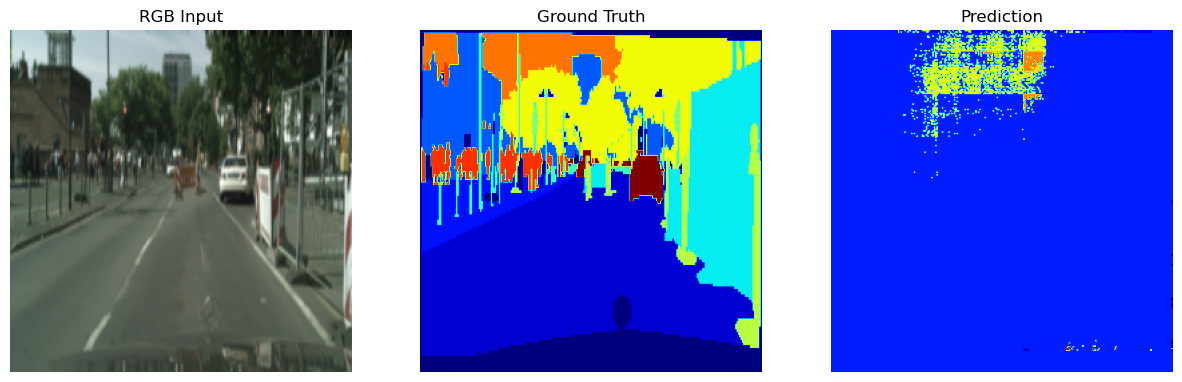

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


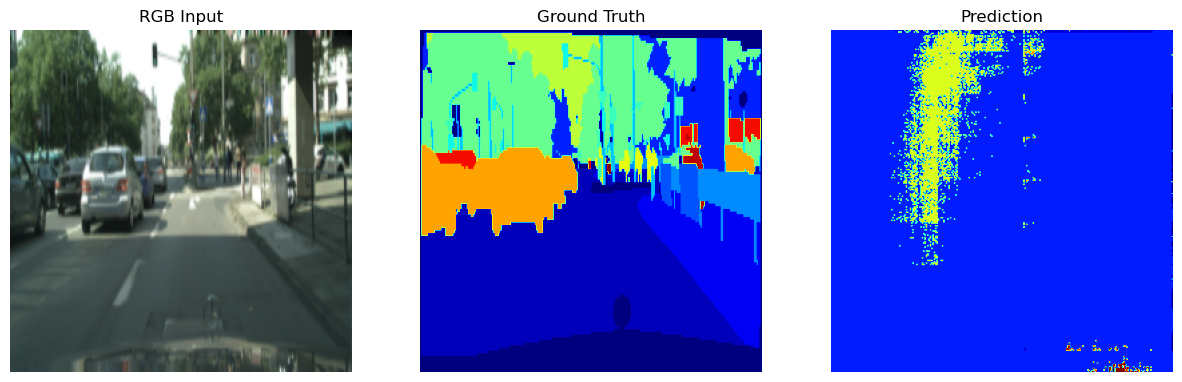

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


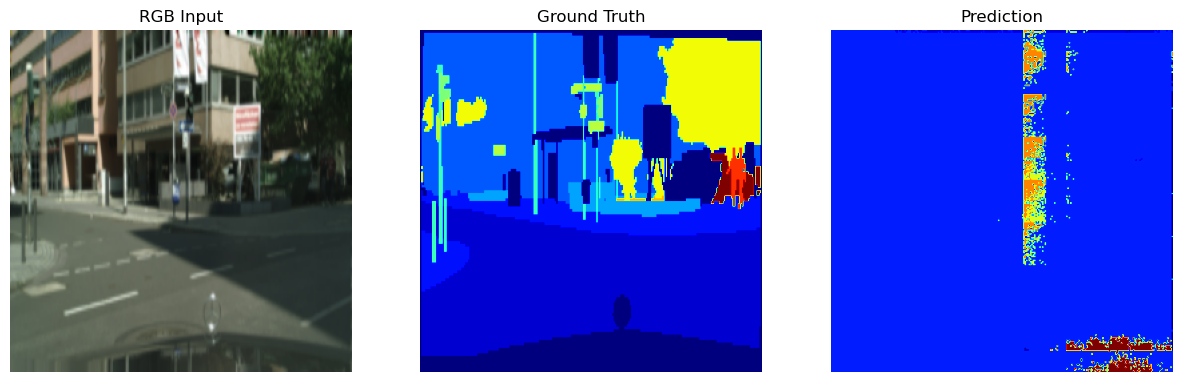

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


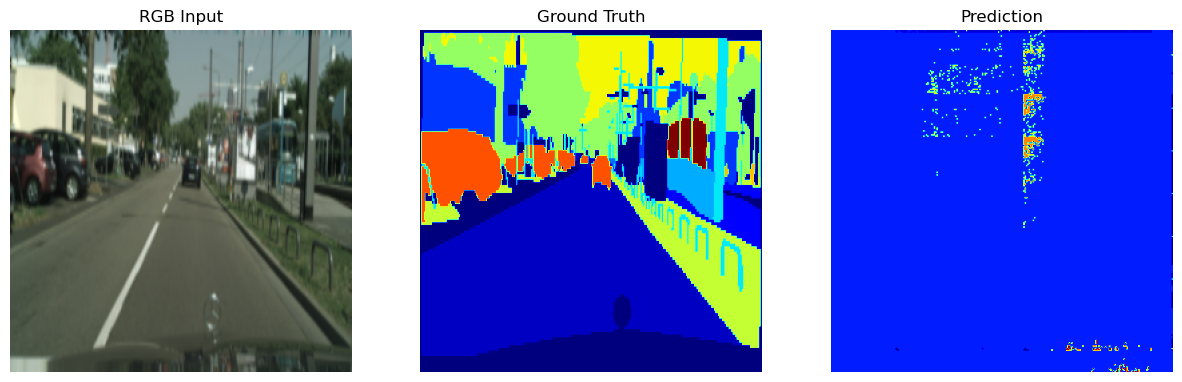

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


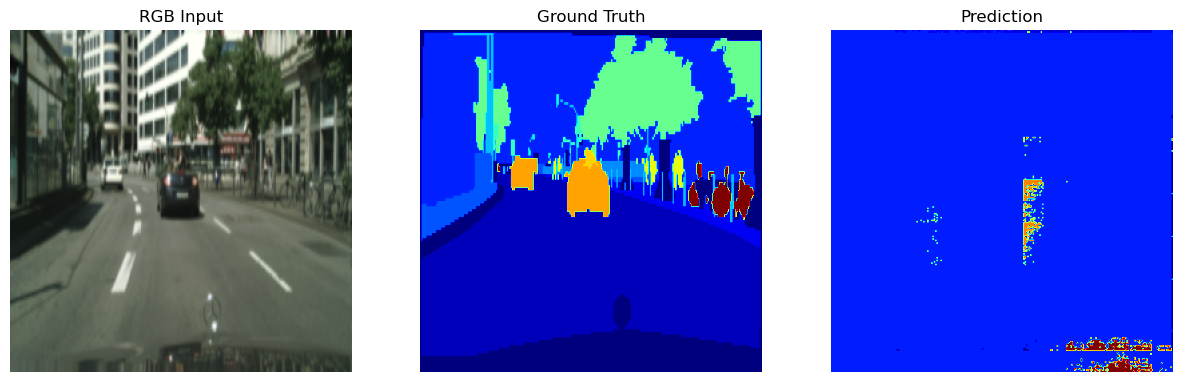

In [53]:
#50/50 - 27s - loss: 0.9340 - accuracy: 0.7286 - 27s/epoch - 547ms/step
#Test loss: 0.934032678604126
#Test accuracy: 0.728630781173706
# Create DataLoader for the test dataset
test_loader = DataLoader(test_rgb_files, test_depth_files, test_label_files, batch_size=32, shuffle=False)

# Evaluate the model on the test dataset
test_loss, test_accuracy = fusion_model.evaluate(test_loader)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Predict and visualize 5 random test examples
num_examples = 5
random_indices = random.sample(range(len(test_rgb_files)), num_examples)

for idx in random_indices:
    # Load one sample from test set
    rgb = np.load(test_rgb_files[idx])
    depth = np.load(test_depth_files[idx])
    label = np.load(test_label_files[idx])
    
    # Preprocess RGB image: resize to 256x256 and ensure 3 channels
    rgb_resized = tf.image.resize(rgb, (256,256)).numpy()
    if rgb_resized.ndim == 2 or rgb_resized.shape[-1] != 3:
        rgb_resized = np.stack([rgb_resized]*3, axis=-1)
    
    # Preprocess Depth image: resize to 256x256 and ensure 3 channels
    depth_resized = tf.image.resize(depth, (256,256)).numpy()
    if depth_resized.ndim == 2 or depth_resized.shape[-1] != 3:
        if depth_resized.ndim == 2:
            depth_resized = np.expand_dims(depth_resized, axis=-1)
        depth_resized = np.repeat(depth_resized, 3, axis=-1)
    
    # Prepare the input batch for prediction (batch size = 1)
    rgb_input = np.expand_dims(rgb_resized, axis=0)
    depth_input = np.expand_dims(depth_resized, axis=0)
    
    # Make prediction: model output is (1, 65536, 19)
    pred = fusion_model.predict((rgb_input, depth_input))
    pred = pred.reshape((256,256,19))
    # Get predicted class for each pixel
    pred_classes = np.argmax(pred, axis=-1)
    
    # Preprocess ground truth label: resize if needed
    if len(label.shape) == 2:
        label_resized = tf.image.resize(np.expand_dims(label, axis=-1), (256,256), method='nearest').numpy()
        label_resized = np.squeeze(label_resized, axis=-1)
    else:
        label_resized = label  # assume already resized
    
    # Visualize the inputs, ground truth, and prediction
    plt.figure(figsize=(15,5))
    
    plt.subplot(1,3,1)
    # If RGB is normalized between 0 and 1, scale it to 0-255 for visualization
    plt.imshow((rgb_resized*255).astype('uint8'))
    plt.title("RGB Input")
    plt.axis('off')
    
    plt.subplot(1,3,2)
    plt.imshow(label_resized, cmap='jet')
    plt.title("Ground Truth")
    plt.axis('off')
    
    plt.subplot(1,3,3)
    plt.imshow(pred_classes, cmap='jet')
    plt.title("Prediction")
    plt.axis('off')
    
    plt.show()


### Extra 5 points :

Implement FCNs for each sing modality and compare their accuracy with fusion model. I need the result of the following table in the same notebook. 

In [28]:

def build_single_stream_fcn(input_shape=(256,256,3), num_classes=19, name_suffix='rgb'):
    """
    Builds a single-stream FCN with ResNet50 backbone for one modality (e.g., RGB).
    """
    # Single input for this modality
    input_modality = Input(shape=input_shape, name=f'input_{name_suffix}')
    
    # Pretrained ResNet50 (include_top=False)
    resnet = ResNet50(weights='imagenet', include_top=False, input_tensor=input_modality, name=f'resnet50_{name_suffix}')
    
    # Output feature maps (e.g., (None, 8, 8, 2048))
    x = resnet.output
    
    # Two Conv2D layers: 128 -> 256 filters
    x = Conv2D(128, (3,3), strides=(1,1), padding='same', activation='relu', name=f'{name_suffix}_conv1')(x)
    x = Conv2D(256, (3,3), strides=(1,1), padding='same', activation='relu', name=f'{name_suffix}_conv2')(x)
    
    # Dropout
    x = Dropout(0.2, name=f'{name_suffix}_dropout')(x)
    
    # Upsample using Conv2DTranspose (kernel=64, stride=32)
    x = Conv2DTranspose(num_classes, (64,64), strides=(32,32), padding='same', activation='relu', name=f'conv2d_transpose_{name_suffix}')(x)
    
    # Reshape to (256*256, num_classes)
    x = Reshape((256*256, num_classes), name=f'reshape_{name_suffix}')(x)
    
    # Softmax activation
    outputs = Activation('softmax', name=f'softmax_{name_suffix}')(x)
    
    model = Model(inputs=input_modality, outputs=outputs, name=f'SingleStreamFCN_{name_suffix}')
    return model


In [30]:

class DataLoaderSingleRGB(Sequence):
    def __init__(self, rgb_files, label_files, batch_size=32, shuffle=True):
        self.rgb_files = rgb_files
        self.label_files = label_files
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.rgb_files))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.rgb_files) / self.batch_size))
    
    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_indexes = self.indexes[start:end]
        
        batch_rgb_files = [self.rgb_files[k] for k in batch_indexes]
        batch_label_files = [self.label_files[k] for k in batch_indexes]
        
        X_rgb, y = self.__generate_data(batch_rgb_files, batch_label_files)
        return X_rgb, y
    
    def __generate_data(self, batch_rgb_files, batch_label_files):
        X_rgb = []
        y = []
        
        for rgb_file, label_file in zip(batch_rgb_files, batch_label_files):
            rgb = np.load(rgb_file)
            label = np.load(label_file)
            
            # Resize RGB to 256x256, ensure 3 channels
            rgb_resized = tf.image.resize(rgb, (256,256)).numpy()
            if rgb_resized.ndim == 2 or rgb_resized.shape[-1] != 3:
                rgb_resized = np.stack([rgb_resized]*3, axis=-1)
            
            # Resize label to 256x256, nearest neighbor
            if len(label.shape) == 2:
                label = np.expand_dims(label, axis=-1)
            label_resized = tf.image.resize(label, (256,256), method='nearest').numpy()
            label_resized = np.squeeze(label_resized, axis=-1)
            
            # One-hot encode label
            label_onehot = tf.one_hot(label_resized.astype(np.int32), depth=19).numpy()
            label_onehot = label_onehot.reshape((256*256, 19))
            
            X_rgb.append(rgb_resized)
            y.append(label_onehot)
        
        return np.array(X_rgb), np.array(y)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)


Training and eval (RGB only)

In [33]:

# Build the RGB-only FCN
rgb_model = build_single_stream_fcn(input_shape=(256,256,3), num_classes=19, name_suffix='rgb')

# Create single-modality dataloaders
train_loader_rgb = DataLoaderSingleRGB(train_rgb_files, train_label_files, batch_size=32, shuffle=True)
val_loader_rgb   = DataLoaderSingleRGB(val_rgb_files, val_label_files, batch_size=32, shuffle=False)
test_loader_rgb  = DataLoaderSingleRGB(test_rgb_files, test_label_files, batch_size=32, shuffle=False)

# Compile
optimizer = SGD(learning_rate=0.01, decay=1e-5, momentum=0.9)
rgb_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train for 10 epochs
history_rgb = rgb_model.fit(train_loader_rgb, validation_data=val_loader_rgb, epochs=10)

# Evaluate on test set
test_loss_rgb, test_accuracy_rgb = rgb_model.evaluate(test_loader_rgb)
print(f"RGB-Only Test Loss: {test_loss_rgb}")
print(f"RGB-Only Test Accuracy: {test_accuracy_rgb}")


Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 508s 25s/step - accuracy: 0.1676 - loss: 2.6200 - val_accuracy: 0.4674 - val_loss: 2.4195
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 471s 25s/step - accuracy: 0.4355 - loss: 2.4514 - val_accuracy: 0.4674 - val_loss: 2.2279
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 380s 20s/step - accuracy: 0.4371 - loss: 2.0308 - val_accuracy: 0.4674 - val_loss: 1.9999
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 377s 20s/step - accuracy: 0.4377 - loss: 1.6563 - val_accuracy: 0.4697 - val_loss: 1.8378
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 386s 20s/step - accuracy: 0.5178 - loss: 1.4829 - val_accuracy: 0.5965 - val_loss: 1.7317
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 394s 21s/step - accuracy: 0.5893 - loss: 1.2932 - val_accuracy: 0.5781 - val_loss: 1.6556
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 383s 20s/step - accuracy: 0.6038 - loss: 1.1498 - val_accuracy: 0.5738 - val_loss: 1.6120
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 362s 19s/step - accuracy: 0.6207 - loss: 1.0493 - val_accuracy: 0.

# For depth

In [36]:
def build_single_stream_fcn_depth(input_shape=(256,256,3), num_classes=19):
    """
    Builds a single-stream FCN with ResNet50 backbone for depth modality only.
    """
    input_modality = Input(shape=input_shape, name='input_depth_only')
    
    resnet = ResNet50(weights='imagenet', include_top=False, input_tensor=input_modality, name='resnet50_depth_only')
    
    x = resnet.output
    
    x = Conv2D(128, (3,3), strides=(1,1), padding='same', activation='relu', name='depth_only_conv1')(x)
    x = Conv2D(256, (3,3), strides=(1,1), padding='same', activation='relu', name='depth_only_conv2')(x)
    x = Dropout(0.2, name='depth_only_dropout')(x)
    
    x = Conv2DTranspose(num_classes, (64,64), strides=(32,32), padding='same', activation='relu', name='conv2d_transpose_depth_only')(x)
    x = Reshape((256*256, num_classes), name='reshape_depth_only')(x)
    outputs = Activation('softmax', name='softmax_depth_only')(x)
    
    model = Model(inputs=input_modality, outputs=outputs, name='SingleStreamFCN_depth')
    return model


In [38]:
class DataLoaderSingleDepth(Sequence):
    def __init__(self, depth_files, label_files, batch_size=32, shuffle=True):
        self.depth_files = depth_files
        self.label_files = label_files
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.depth_files))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.depth_files) / self.batch_size))
    
    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_indexes = self.indexes[start:end]
        
        batch_depth_files = [self.depth_files[k] for k in batch_indexes]
        batch_label_files = [self.label_files[k] for k in batch_indexes]
        
        X_depth, y = self.__generate_data(batch_depth_files, batch_label_files)
        return X_depth, y
    
    def __generate_data(self, batch_depth_files, batch_label_files):
        X_depth = []
        y = []
        
        for depth_file, label_file in zip(batch_depth_files, batch_label_files):
            depth = np.load(depth_file)
            label = np.load(label_file)
            
            # Resize depth to 256x256, ensure 3 channels
            depth_resized = tf.image.resize(depth, (256,256)).numpy()
            if depth_resized.ndim == 2 or depth_resized.shape[-1] != 3:
                if depth_resized.ndim == 2:
                    depth_resized = np.expand_dims(depth_resized, axis=-1)
                depth_resized = np.repeat(depth_resized, 3, axis=-1)
            
            # Resize label
            if len(label.shape) == 2:
                label = np.expand_dims(label, axis=-1)
            label_resized = tf.image.resize(label, (256,256), method='nearest').numpy()
            label_resized = np.squeeze(label_resized, axis=-1)
            
            # One-hot encode label
            label_onehot = tf.one_hot(label_resized.astype(np.int32), depth=19).numpy()
            label_onehot = label_onehot.reshape((256*256, 19))
            
            X_depth.append(depth_resized)
            y.append(label_onehot)
        
        return np.array(X_depth), np.array(y)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [40]:
# Build the Depth-only FCN
depth_model = build_single_stream_fcn_depth(input_shape=(256,256,3), num_classes=19)

# Create single-modality dataloaders
train_loader_depth = DataLoaderSingleDepth(train_depth_files, train_label_files, batch_size=32, shuffle=True)
val_loader_depth   = DataLoaderSingleDepth(val_depth_files, val_label_files, batch_size=32, shuffle=False)
test_loader_depth  = DataLoaderSingleDepth(test_depth_files, test_label_files, batch_size=32, shuffle=False)

# Compile
optimizer = SGD(learning_rate=0.01, decay=1e-5, momentum=0.9)
depth_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train for 10 epochs
history_depth = depth_model.fit(train_loader_depth, validation_data=val_loader_depth, epochs=10)

# Evaluate on test set
test_loss_depth, test_accuracy_depth = depth_model.evaluate(test_loader_depth)
print(f"Depth-Only Test Loss: {test_loss_depth}")
print(f"Depth-Only Test Accuracy: {test_accuracy_depth}")


Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 462s 22s/step - accuracy: 0.1636 - loss: 2.6084 - val_accuracy: 0.4674 - val_loss: 2.4205
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 366s 19s/step - accuracy: 0.4295 - loss: 2.4590 - val_accuracy: 0.4674 - val_loss: 2.2219
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 353s 19s/step - accuracy: 0.4378 - loss: 2.0129 - val_accuracy: 0.4674 - val_loss: 2.0189
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 356s 19s/step - accuracy: 0.4345 - loss: 1.6939 - val_accuracy: 0.4647 - val_loss: 1.9216
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 353s 19s/step - accuracy: 0.4919 - loss: 1.5259 - val_accuracy: 0.5388 - val_loss: 1.8197
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 354s 19s/step - accuracy: 0.5910 - loss: 1.3709 - val_accuracy: 0.4935 - val_loss: 1.7760
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 354s 19s/step - accuracy: 0.5919 - loss: 1.2392 - val_accuracy: 0.4777 - val_loss: 1.7255
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 352s 19s/step - accuracy: 0.6004 - loss: 1.1260 - val_accuracy: 0.

# RESULT

| **Modality** | **Test Accuracy(%)** |
| -------- | -------- |
| RGB only | ~53% |
| Depth Only | ~37% |
| RBB and Depth Fusion | ~24.5%  |

refrences:
https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet50
https://www.tensorflow.org/api_docs/python/tf/image/resize
https://keras.io/api/layers/convolution_layers/
https://keras.io/api/layers/regularization_layers/dropout/
https://keras.io/api/optimizers/sgd/
and numerous stackoverflow links.

**NOTE:**
By fine-tuning the last 10 layers of each ResNet50 branch (i.e., unfreezing them) and reducing the batch size from 32 to 16, we observed notable changes in model performance:

Fine-Tuning of Pretrained Layers:
Unfreezing the last 10 layers allowed the model to adjust the pretrained feature extractors to the specific characteristics of our road scene segmentation task. This resulted in improved training accuracy (rising from around 70% to over 76%) and a lower training loss.

Reduced Batch Size:
Lowering the batch size to 16 increased the frequency of weight updates per epoch (i.e., more gradient steps), which often allows the model to adjust more rapidly and can improve training performance.

Although the training accuracy improved significantly with these changes, the validation accuracy dropped to around 20% compared to a higher value in previous configurations. This suggests that while the model learned the training data more effectively (possibly even memorizing certain patterns), it did not generalize well to unseen data (overfitting).